#Comparison of protein sequences
Comparison and analysis of two protein sequences in terms of sequence alignment using dot plots.
####Agneiszka Brdys

###Installation of the Biopython:

In [1]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.3 MB/s eta 0:00:00


###Loading sequence from a FASTA file:
The function returns the sequence stored in the .fasta file or returns information if the file does not exist or contains incorrect data.

In [2]:
from Bio import SeqIO

def read_seq_from_filepath(path):
  try:

    with open(path, "r") as handle:
      for record in SeqIO.parse(handle, "fasta"):
          if str(record.seq).isalpha():
            print(record)
          else:
            print("The sequence contains illegal characters.")

  except(FileNotFoundError):
    print("The file does not exist.")

path = "sample_data/human_mouse_prot.fasta"
read_seq_from_filepath(path)

The file does not exist.


###Loading sequence based on ID from the UniProt service:
The function returns the sequence based on the ID from the UniProt service or returns information if an incorrect ID is provided.

In [4]:
from Bio.SeqIO.UniprotIO import UniprotIterator
from Bio import SeqIO
from Bio import ExPASy

def read_seq_from_uniprot(uniprot_id):
  try:

    with ExPASy.get_sprot_raw(uniprot_id) as handle:
      for record in SeqIO.parse(handle, "swiss"):
          return record.seq

  except(ValueError):
    print("The provided ID does not exist in the UniProt database.")

uniprot_id = "P38398"
read_seq_from_uniprot(uniprot_id)

Seq('MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKFCMLKLLNQ...SHY')

###Assumptions (pseudocode)
Class DotPlot:

1. Method init:

  args: sequence 1, sequence 2, threshold, window, whether to filter, path to file

  Initialize sequence 1, sequence 2, threshold, window, whether to filter, path to file

  Set matrix to None

2. Method initialize matrix:

  Initialize matrix as a zeros matrix of size length of sequence 1 x length of sequence 2

3. Method fill matrix:

  For each index i in the range from 0 to length of sequence 1 and for each index j in the range from 0 to length of sequence 2:

  If sequence 1[i] equals sequence 2[j], set matrix[i, j] to 1

4. Method print diagonals:

  Initialize diagonal list as an empty list

  For each i in the range from 1 to number of matrix rows (inclusive), create diagonal by fetching diagonals of matrix with offset k equals number of matrix rows - i. Add diagonal to diagonal list

  For each j in the range from 0 to minus number of matrix columns (inclusive), with step -1, create diagonal by fetching diagonal of matrix with offset k equals j. Add diagonal to diagonal list

  Return diagonal list

5. Method filter diagonals:

  args: list of diagonals

  Initialize filtered diagonals list as an empty list

  For each diagonal in the list of diagonals, create a copy of diagonal and for each j in the range from 0 to length of diagonal, create a split diagonal by fetching a segment of diagonal from j to j + length of window

  If the sum of split_diagonal is less than threshold, set diagonal[j] to 0

  Add diagonal to filtered diagonals list

  Return filtered diagonals list

6. Method filter matrix

  args: list of filtered diagonals

  Initialize rows as number of matrix rows

  Initialize columns as number of matrix columns

  Initialize matrix as a zeros matrix of size (rows, columns) and type int

  For each i in the range from 0 to number of rows, fill matrix diagonal (from column-i-1 to end) with values from list of filtered diagonals[i]

  For each j in the range from 1 to number of rows, set diagonal index as columns+j-1 and fill matrix diagonal (from row j to end) with values from list of filtered diagonals[diagonal index]

7. Method create dot plot:

  Call initialize matrix method

  Call fill matrix method

  If filter is set to True, call print diagonals, filter diagonals, and filter matrix

  Save the plot to a file at the provided path excluding unnecessary margins

  Display the plot

###Class generating a dot plot matrix:
as well as saving the generated plot to a graphical file.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

class DotPlot:
    def __init__(self, seq1, seq2, threshold=None, window_size=None, filter=True, filepath='dot-plot.png'):
        self.seq1 = seq1
        self.seq2 = seq2
        self.threshold = threshold
        self.window_size = window_size
        self.filter = filter
        self.filepath = filepath
        self.matrix = None

    def initialize_matrix(self):
        self.matrix = np.zeros((len(self.seq1), len(self.seq2)))

    def fill_matrix(self):
        for i in range(len(self.seq1)):
            for j in range(len(self.seq2)):
                if self.seq1[i] == self.seq2[j]:
                    self.matrix[i, j] = 1

    def extract_diagonals(self):
        rows, columns = self.matrix.shape
        diagonals_list = []
        for i in range(1, rows, 1):
            diagonal = np.diag(self.matrix, k=rows-i)
            diagonals_list.append(diagonal)
        for j in range(0, -columns, -1):
            diagonal = np.diag(self.matrix, k=j)
            diagonals_list.append(diagonal)
        return diagonals_list

    def filter_diagonals(self, diagonals_list):
        filtered_diagonals = []
        for i in range(len(diagonals_list)):
            diagonal = diagonals_list[i].copy()
            for j in range(len(diagonal)):
                splited_diagonal = diagonal[j:j+self.window_size]
                if np.sum(splited_diagonal) < self.threshold:
                    diagonal[j] = 0
            filtered_diagonals.append(diagonal)
        return filtered_diagonals

    def filter_matrix(self, filtered_diagonals):
        rows, cols = self.matrix.shape
        self.matrix = np.zeros((rows, cols), dtype=int)
        for i in range(cols):
            np.fill_diagonal(self.matrix[:,cols-i-1:], filtered_diagonals[i])
        for j in range(1, rows):
            diagonl_index = cols + j - 1
            np.fill_diagonal(self.matrix[j:], filtered_diagonals[diagonl_index])

    def create_dot_plot(self):
        self.initialize_matrix()
        self.fill_matrix()

        if self.filter:
            diagonals_list = self.extract_diagonals()
            filtered_diagonals = self.filter_diagonals(diagonals_list)
            self.filter_matrix(filtered_diagonals)

        plt.figure(figsize=(10,10))
        plt.imshow(self.matrix, cmap='Greys', interpolation='none')
        plt.xlim(0, len(self.seq2)-1)
        plt.ylim(0, len(self.seq1)-1)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('Sequence 2')
        plt.ylabel('Sequence 1')
        plt.title('Sequences comparision')
        plt.savefig(self.filepath, bbox_inches='tight')
        plt.show()


###Program call for a pair of evolutionarily related sequences.
Without filtering:

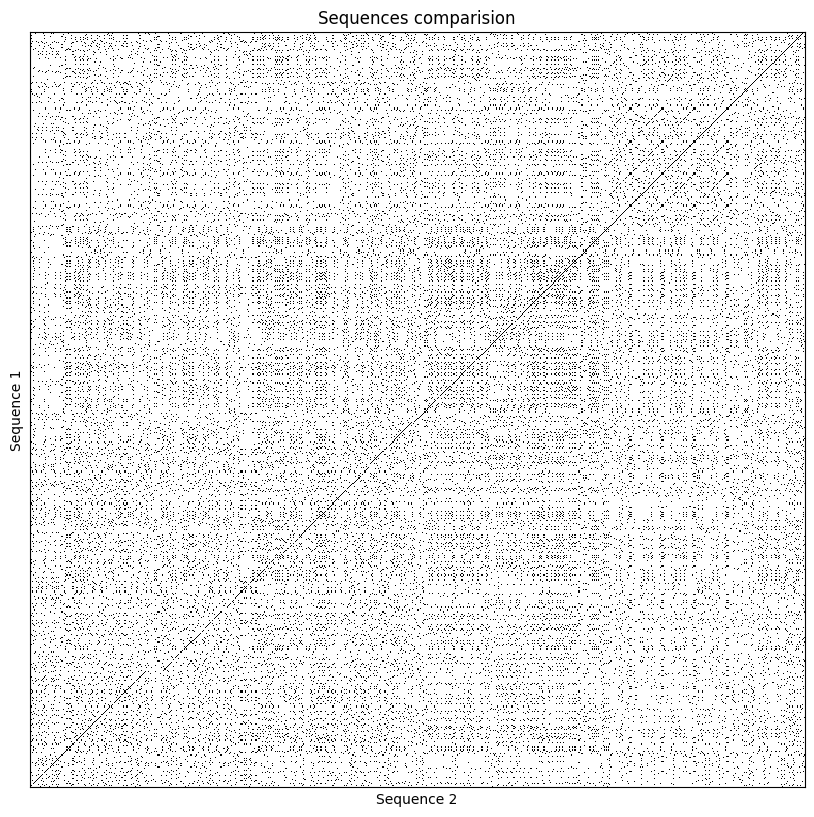

In [6]:
# Example protein sequences
seq1 = read_seq_from_uniprot("P10637") # mouse tau prot
seq2 = read_seq_from_uniprot("P19332") # rat tau prot
threshold = 2  # Filtering threshold
window_size = 3  # Window size

# Generating dot-plot
DotPlot(seq1, seq2, filter=False, filepath='related_without_fiter.png').create_dot_plot()

With filtering:

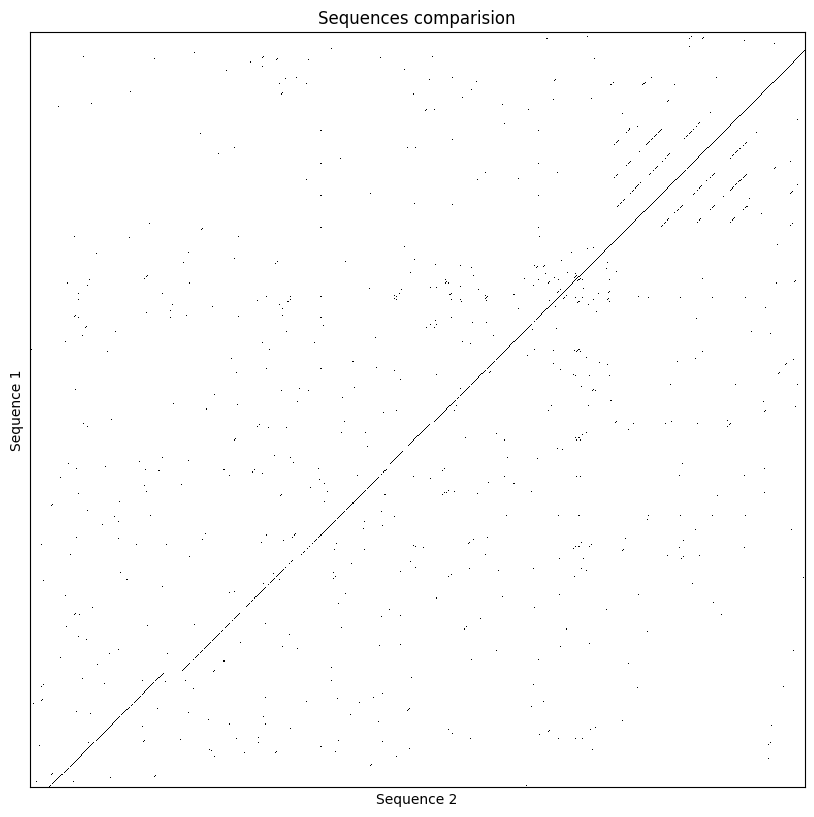

In [7]:
# Example protein sequences
seq1 = read_seq_from_uniprot("P10637") # mouse tau prot
seq2 = read_seq_from_uniprot("P19332") # rat tau prot
threshold = 3  # Filtering threshold
window_size = 4  # Window size

# Generating dot-plot
DotPlot(seq1, seq2, threshold, window_size, filter=True, filepath='related_with_filter.png').create_dot_plot()

###Program call for evolutionarily unrelated sequences.
Without filtering:

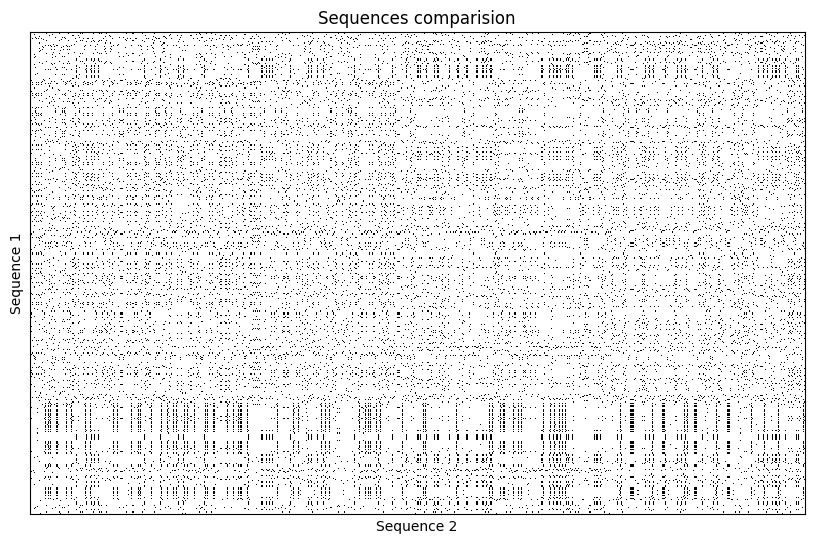

In [8]:
# Example protein sequences
seq1 = read_seq_from_uniprot("P02533") # human keratin
seq2 = read_seq_from_uniprot("P10636") # human tau prot
threshold = 3  # Filtering threshold
window_size = 4  # Window size

# Generating dot-plot
DotPlot(seq1, seq2, threshold, window_size, filter=False, filepath='nrelated_without_filter.png').create_dot_plot()

With filtering:

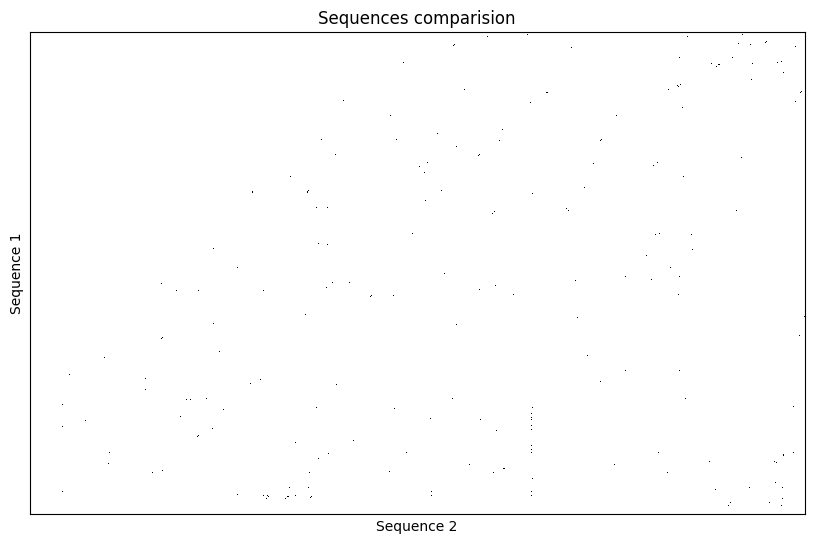

In [9]:
# Example protein sequences
seq1 = read_seq_from_uniprot("P02533") # human keratin
seq2 = read_seq_from_uniprot("P10636") # human tau prot
threshold = 3  # Filtering threshold
window_size = 4  # Window size

# Generating dot-plot
DotPlot(seq1, seq2, threshold, window_size, filter=True, filepath='nunrelated_with_filter.png').create_dot_plot()

##Computational complexity analysis
###Reading from a FASTA file
Sequence parsing O(n), where n is the length of the sequence.

Validity check O(n).

Linear computational complexity.

###Reading from the UniProt service
Sequence parsing O(n), where n is the length of the sequence.

Linear computational complexity.

###Plot generation function
Matrix filling - O(m x n), quadratic complexity,

Printing diagonals - O(max(m, n)), linear complexity,

Diagonal filtering - O((m+n+-1) x min(m, n)), quadratic complexity,

Matrix filtering - O(min(m, n)), linear complexity,

where n and m are the lengths of the sequences.

The highest computational complexity is quadratic.

##Plots Analysis
###Pair of Related Sequences:
The same proteins from different organisms have evolutionarily related sequences. This is due to these proteins performing the same functions. On the plot, a high similarity can be observed between the mouse and rat tau proteins. This is indicated by the prominent line along the main diagonal.

Throughout the length, discontinuities in the line can be observed, which likely indicate substitutions that have occurred. The line is also shifted relative to the main diagonal, as visible in the upper-right and lower-left corners of the plot. This may suggest insertions in the second sequence relative to the first, or deletions in the first sequence relative to the second.

Short lines offset from the main diagonal in the upper part of the plot may indicate repetitions of short amino acid sequence fragments occurring in multiple places within the sequences.

###Pair of Unrelated Sequences:
Unrelated sequences have proteins with different functionalities. The plot depicts keratin and human tau protein.

Significant differences in sequence length can be observed. After filtering, aligned fragments can be seen, but these are mostly individual points, suggesting random matches.